<a href="https://colab.research.google.com/github/dyfzl/AI-/blob/main/%EB%AC%B8%EC%B2%B4%EC%99%80%20%EA%B0%90%EC%A0%95%EC%9D%98%20%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84%20%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00


In [37]:
!pip install datasets


In [ ]:
import os

# WandB 비활성화
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
from datasets import Dataset
from transformers import EarlyStoppingCallback
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive/')

# 데이터 로드
path = '/content/drive/MyDrive/소설작가분류/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test_x.csv')

Mounted at /content/drive/


In [ ]:
# 1. 데이터 전처리
# 문체 보존 전처리 함수
def clean_text_preserve_style(text):
    import re
    text = re.sub(r"[^\w\s.,!?']", "", text)  # 쉼표, 마침표, 느낌표, 작은따옴표 유지
    text = re.sub(r"\s+", " ", text).strip()  # 불필요한 공백 제거
    return text

# 1번 코드: 문체 보존 전처리 적용
train["text"] = train["text"].apply(clean_text_preserve_style)
test["text"] = test["text"].apply(clean_text_preserve_style)

# 감성 라벨 추가
from textblob import TextBlob

def sentiment_textblob(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# 감성 라벨 추가 (문체 반영한 1번 코드와 문체 반영 없는 2번 코드 동일)
train["sentiment"] = train["text"].apply(sentiment_textblob)
sentiment_mapping = {"Positive": 1, "Negative": 0, "Neutral": 2}
train["sentiment_label"] = train["sentiment"].map(sentiment_mapping)


In [ ]:
# 학습/테스트 데이터 분할
train_data, test_data = train_test_split(train, test_size=0.2, stratify=train["sentiment_label"], random_state=42)

# 데이터셋 생성
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# 2. 데이터 전처리 함수 (토큰화)
model_name = "distilbert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocess_data(batch):
    return tokenizer(
        batch["text"],  # 텍스트 열 이름
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/43903 [00:00<?, ? examples/s]

Map:   0%|          | 0/10976 [00:00<?, ? examples/s]

In [ ]:
# 'labels' 컬럼 추가
train_dataset = train_dataset.map(lambda x: {"labels": x["sentiment_label"]})
test_dataset = test_dataset.map(lambda x: {"labels": x["sentiment_label"]})

# 데이터 포맷 설정
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# 3. 모델 정의 (DistilBERT for Sequence Classification)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)


Map:   0%|          | 0/43903 [00:00<?, ? examples/s]

Map:   0%|          | 0/10976 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 4. 학습 설정
training_args = TrainingArguments(
    output_dir="./sentiment_analysis_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    fp16=True,  # Mixed precision
)

# EarlyStoppingCallback 추가
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[early_stopping]
)

# 5. 학습 (문체 반영 모델 학습)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-5577032eddc3>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.340000,0.243557
2,0.247100,0.238006
3,0.275100,0.245841


TrainOutput(global_step=16464, training_loss=0.23308523390720443, metrics={'train_runtime': 992.4489, 'train_samples_per_second': 132.711, 'train_steps_per_second': 16.589, 'total_flos': 4361864938677504.0, 'train_loss': 0.23308523390720443, 'epoch': 3.0})

In [ ]:
# 6. 평가 (문체 반영 모델)
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = test_dataset["labels"]

# 성능 평가
print("Performance for 1번 코드 (문체 반영 모델):")
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive", "Neutral"]))


Performance for 1번 코드 (문체 반영 모델):
Accuracy: 0.9406
              precision    recall  f1-score   support

    Negative       0.94      0.84      0.89      2654
    Positive       0.91      0.97      0.94      4937
     Neutral       0.98      0.97      0.98      3385

    accuracy                           0.94     10976
   macro avg       0.95      0.93      0.94     10976
weighted avg       0.94      0.94      0.94     10976



In [45]:
# 토큰화 적용
train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

Map:   0%|          | 0/10976 [00:00<?, ? examples/s]

In [ ]:
# 7. 문체 미반영 모델 학습
# 모델 초기화 (DistilBERT 재사용)
model_no_style = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Trainer 재정의 (문체 미반영 모델)
trainer_no_style = Trainer(
    model=model_no_style,
    args=training_args,
    train_dataset=train_dataset,  # 동일 데이터 사용
    eval_dataset=test_dataset,   # 동일 데이터 사용
    tokenizer=tokenizer,
    callbacks=[early_stopping]
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-d9ceeb47cee8>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_no_style = Trainer(


In [ ]:
# 학습 (문체 미반영 모델)
trainer_no_style.train()


Epoch,Training Loss,Validation Loss
1,0.280500,0.232504
2,0.343800,0.230608
3,0.198600,0.233226


TrainOutput(global_step=16464, training_loss=0.2356853233132171, metrics={'train_runtime': 982.1192, 'train_samples_per_second': 134.107, 'train_steps_per_second': 16.764, 'total_flos': 4361864938677504.0, 'train_loss': 0.2356853233132171, 'epoch': 3.0})

In [ ]:
# 평가 (문체 미반영 모델)
predictions_no_style = trainer_no_style.predict(test_dataset)
predicted_labels_no_style = predictions_no_style.predictions.argmax(axis=-1)

# 성능 평가
print("\nPerformance for 2번 코드 (문체 미반영 모델):")
accuracy_no_style = accuracy_score(true_labels, predicted_labels_no_style)
print(f"Accuracy: {accuracy_no_style:.4f}")
print(classification_report(true_labels, predicted_labels_no_style, target_names=["Negative", "Positive", "Neutral"]))



Performance for 2번 코드 (문체 미반영 모델):
Accuracy: 0.9416
              precision    recall  f1-score   support

    Negative       0.94      0.84      0.89      2654
    Positive       0.92      0.97      0.94      4937
     Neutral       0.98      0.97      0.98      3385

    accuracy                           0.94     10976
   macro avg       0.95      0.93      0.94     10976
weighted avg       0.94      0.94      0.94     10976



In [ ]:
# 8. 성능 비교
print("\nComparison of Sentiment Analysis Performance:")
print(f"1번 코드 (문체 반영 모델) Accuracy: {accuracy:.4f}")
print(f"2번 코드 (문체 미반영 모델) Accuracy: {accuracy_no_style:.4f}")




Comparison of Sentiment Analysis Performance:
1번 코드 (문체 반영 모델) Accuracy: 0.9406
2번 코드 (문체 미반영 모델) Accuracy: 0.9416


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-package

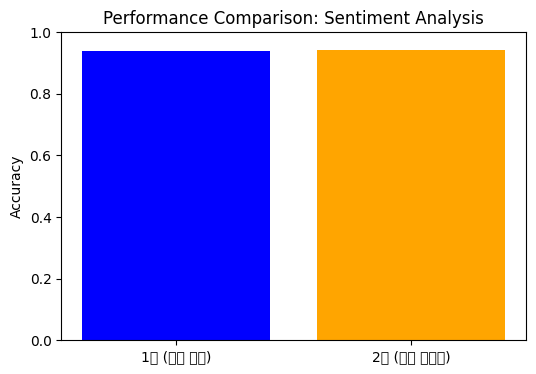

In [ ]:
# 성능 비교 요약 시각화
import matplotlib.pyplot as plt

performance_data = {
    "Model": ["1번 (문체 반영)", "2번 (문체 미반영)"],
    "Accuracy": [accuracy, accuracy_no_style]
}
performance_df = pd.DataFrame(performance_data)

plt.figure(figsize=(6, 4))
plt.bar(performance_df["Model"], performance_df["Accuracy"], color=["blue", "orange"])
plt.title("Performance Comparison: Sentiment Analysis")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()